In [1]:
from __future__ import print_function, division
import time

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
import math
import pickle
import numpy as np
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt

# Util methods

In [2]:
def init_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)
        
def save_image(img, path, mean, std):
  img = img.copy()
  img *= std
  img += mean
  img = img.astype(np.uint8)
  ski.io.imsave(path, img)

def show_image(img, mean, std):
  img = img.copy()
  img *= std
  img += mean
  img = img.astype(np.uint8)
  ski.io.imshow(img)
  ski.io.show()

def shuffle_data(data_x, data_y):
  indices = np.arange(data_x.shape[0])
  np.random.shuffle(indices)
  shuffled_data_x = np.ascontiguousarray(data_x[indices])
  shuffled_data_y = np.ascontiguousarray(data_y[indices])
  return shuffled_data_x, shuffled_data_y

def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict


def get_label_names(blob):
    label_dict = unpickle(blob)['label_names']
    return np.array(label_dict)

# Params

In [3]:
DATA_DIR = '/home/mratkovic/deeplearning/datasets/cifar-10-batches-py/'
SAVE_DIR = '/home/mratkovic/deeplearning/outputs/cifar10/'
init_dir(SAVE_DIR)

config = {}
config['max_epochs'] = 40
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['weight_decay'] = 1e-4
lr_initial = 0.01
config['lr_policy'] = {e:{'lr':(0.9**e)*lr_initial} for e in range(1, config['max_epochs']+1)}

# Dataset

In [4]:
img_height, img_width, num_channels = 32, 32, 3
train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
  subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
  train_x = np.vstack((train_x, subset['data']))
  train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std
print(train_x.shape)

weight_decay = config['weight_decay']
n_classes = 10

class_names = get_label_names(os.path.join(DATA_DIR, 'batches.meta'))
print(class_names)

(45000, 32, 32, 3)
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


# Util methods for tf

In [5]:
def l2_loss(weights):
    regularizers = 0;
    for w in weights:
        regularizers += tf.nn.l2_loss(w)
    return regularizers
        

def conv2d(x, W, b, activation=tf.nn.relu, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return activation(x)

def maxpool2d(x, k=2, stride=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], padding='SAME')

def fc(x, W, b, activation=None):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    if activation :
        return activation(tf.matmul(x, W) +  b)    
    return tf.matmul(x, W) +  b



# Network

In [6]:
from tensorflow.contrib.layers import xavier_initializer_conv2d as xavier_conv2d
from tensorflow.contrib.layers import xavier_initializer as xavier
tf.reset_default_graph()

weights = {
    'conv1': tf.get_variable('w_conv1', [5, 5, 3, 16], initializer=xavier_conv2d()),
    'conv2': tf.get_variable('w_conv2', [5, 5, 16, 32], initializer=xavier_conv2d()),
    
    'fc3': tf.get_variable('w_fc3', [8*8*32, 256], initializer=xavier()),
    'fc4': tf.get_variable('w_fc4', [256, 128], initializer=xavier()),
    'fc5': tf.get_variable('w_fc5', [128, n_classes], initializer=xavier())
    
}

biases = {
    'conv1': tf.Variable(tf.zeros([16]), name='b_conv1'),
    'conv2': tf.Variable(tf.zeros([32]), name='b_conv2'),
    
    'fc3': tf.Variable(tf.zeros([256]), name='b_fc3'),
    'fc4': tf.Variable(tf.zeros([128]), name='b_fc4'),
    'fc5': tf.Variable(tf.zeros([n_classes]), name='b_fc5')
}

#conv(16,5) -> pool(3,2) -> conv(32,5) -> pool(3,2) -> fc(256) -> fc(128) -> fc(10)
def convnet(x, weights, biases):
    x = tf.reshape(x, shape=[-1, img_height, img_width, num_channels])
    net = conv2d(x, weights['conv1'], biases['conv1'], tf.nn.relu)
    net = maxpool2d(net, k=3, stride=2)
    
    net = conv2d(net, weights['conv2'], biases['conv2'], tf.nn.relu)
    net = maxpool2d(net, k=3, stride=2)
    
    net = fc(net, weights['fc3'],  biases['fc3'], tf.nn.relu)
    net = fc(net, weights['fc4'],  biases['fc4'], tf.nn.relu)
    net = fc(net, weights['fc5'],  biases['fc5'])
    return net


# Graph
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y_ = tf.placeholder(tf.int32, [None,])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss(weights.values())
loss_per_sample = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, Y_)
data_loss = tf.reduce_mean(loss_per_sample)
loss = data_loss + weight_decay*regularizers


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 900, 0.9, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

# Train

In [7]:
def train(session, train_x, train_y, valid_x, valid_y, config, plot_data={}):
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    
    session.run(tf.initialize_all_variables())
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    
    for epoch_num in range(1, max_epochs + 1):
      epoch_start = time.time()
      train_x, train_y = shuffle_data(train_x, train_y)
    
      for step in range(num_batches):
        offset = step * batch_size 
        
        batch_x = train_x[offset:(offset + batch_size), ...]
        batch_y = train_y[offset:(offset + batch_size), ...]
        
        feed_dict = {X: batch_x, Y_: batch_y}
        start_time = time.time()
        ret_val = session.run([train_step, loss, logits], feed_dict=feed_dict)
        _, loss_val, logits_val = ret_val
        duration = time.time() - start_time
        
        if (step+1) % 50 == 0:
          sec_per_batch = float(duration)
          format_str = 'epoch %d, step %d / %d, loss = %.2f (%.3f sec/batch)'
          print(format_str % (epoch_num, step+1, num_batches, loss_val, sec_per_batch))
        
        if (step+1) % 100 == 0:
            w = session.run(weights['conv1'])
            draw_conv_filters(epoch_num, step+1, w, save_dir)

      print('Train error:')
      train_loss, train_acc = evaluate(session, train_x, train_y, config)
      print('Validation error:')
      valid_loss, valid_acc = evaluate(session, valid_x, valid_y, config)
      print('Epoch time:', time.time() - epoch_start)
      plot_data['train_loss'] += [train_loss]
      plot_data['valid_loss'] += [valid_loss]
      plot_data['train_acc'] += [train_acc]
      plot_data['valid_acc'] += [valid_acc]
      plot_data['lr'] += [session.run(learning_rate)]
      plot_training_progress(plot_data, SAVE_DIR)
    return plot_data

        

# Evaluate

In [8]:
def evaluate(session, x, y, config):
  batch_size = config['batch_size']
  num_examples = x.shape[0]
  assert num_examples % batch_size == 0
  num_batches = num_examples // batch_size
  cnt_correct = 0
  loss_avg = 0


  for i in range(num_batches):
    batch_x = x[i*batch_size:(i+1)*batch_size, ...]
    batch_y = y[i*batch_size:(i+1)*batch_size, ...]
    
    data_dict = {X: batch_x, Y_: batch_y}
    logits_val, loss_val = session.run([logits, loss] ,feed_dict=data_dict)
    
    yp = np.argmax(logits_val, 1)
    yt = batch_y
    cnt_correct += (yp == yt).sum()

    loss_avg += loss_val
  valid_acc = cnt_correct / num_examples * 100
  loss_avg /= num_batches
    
  print(" accuracy = %.2f" % valid_acc)
  print(" avg loss = %.2f\n" % loss_avg)
  return loss_avg, valid_acc


In [9]:
def worst_samples(session, x, y, config):
  batch_size = config['batch_size']
  num_examples = x.shape[0]
  num_batches = num_examples // batch_size

  worst_samples = []
  for i in range(num_batches):
    batch_x = x[i*batch_size:(i+1)*batch_size, ...]
    batch_y = y[i*batch_size:(i+1)*batch_size, ...]
    
    data_dict = {X: batch_x, Y_: batch_y}
    loss_vals, logits_val = session.run([loss_per_sample, logits] ,feed_dict=data_dict)
    prediction = np.argmax(logits_val, 1)
    loss_pairs = [(i*batch_size+id, loss, p) for id, (loss, p) in enumerate(zip(loss_vals, prediction))]
    worst_samples = sorted(loss_pairs + worst_samples, key=lambda x: -x[1])[:20]
  return worst_samples
    
    




# Plot methods

In [10]:
def draw_conv_filters(epoch, step, weights, save_dir):
  w = weights.copy()
  num_filters = w.shape[3]
  num_channels = w.shape[2]
  k = w.shape[0]
  assert w.shape[0] == w.shape[1]
  w = w.reshape(k, k, num_channels, num_filters)
  w -= w.min()
  w /= w.max()
  border = 1
  cols = 8
  rows = math.ceil(num_filters / cols)
  width = cols * k + (cols-1) * border
  height = rows * k + (rows-1) * border
  img = np.zeros([height, width, num_channels])
  for i in range(num_filters):
    r = int(i / cols) * (k + border)
    c = int(i % cols) * (k + border)
    img[r:r+k,c:c+k,:] = w[:,:,:,i]
  filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
  ski.io.imsave(os.path.join(save_dir, filename), img)

def plot_training_progress(data, save_dir=None):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)
  if save_dir is not None:
    save_path = os.path.join(save_dir, 'training_plot.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)
    plt.close()
  else:
    plt.show()
    

# Runner

In [11]:
session = tf.Session()
train_start = time.time()

plot_data={}
train(session, train_x, train_y, valid_x, valid_y, config, plot_data)

print("Total train time:", time.time() - train_start)

epoch 1, step 50 / 900, loss = 2.21 (0.006 sec/batch)
epoch 1, step 100 / 900, loss = 1.98 (0.006 sec/batch)


/home/mratkovic/.virtualenvs/py27_tf_env/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mratkovic/.virtualenvs/py27_tf_env/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


epoch 1, step 150 / 900, loss = 1.85 (0.006 sec/batch)
epoch 1, step 200 / 900, loss = 1.63 (0.006 sec/batch)
epoch 1, step 250 / 900, loss = 2.04 (0.006 sec/batch)
epoch 1, step 300 / 900, loss = 1.95 (0.006 sec/batch)
epoch 1, step 350 / 900, loss = 1.85 (0.006 sec/batch)
epoch 1, step 400 / 900, loss = 1.59 (0.006 sec/batch)
epoch 1, step 450 / 900, loss = 1.56 (0.006 sec/batch)
epoch 1, step 500 / 900, loss = 1.71 (0.006 sec/batch)
epoch 1, step 550 / 900, loss = 1.70 (0.006 sec/batch)
epoch 1, step 600 / 900, loss = 1.68 (0.006 sec/batch)
epoch 1, step 650 / 900, loss = 1.69 (0.007 sec/batch)
epoch 1, step 700 / 900, loss = 1.49 (0.006 sec/batch)
epoch 1, step 750 / 900, loss = 1.32 (0.006 sec/batch)
epoch 1, step 800 / 900, loss = 1.44 (0.007 sec/batch)
epoch 1, step 850 / 900, loss = 1.55 (0.006 sec/batch)
epoch 1, step 900 / 900, loss = 1.41 (0.006 sec/batch)
Train error:
 accuracy = 50.49
 avg loss = 1.42

Validation error:
 accuracy = 49.08
 avg loss = 1.44

Epoch time: 7.396

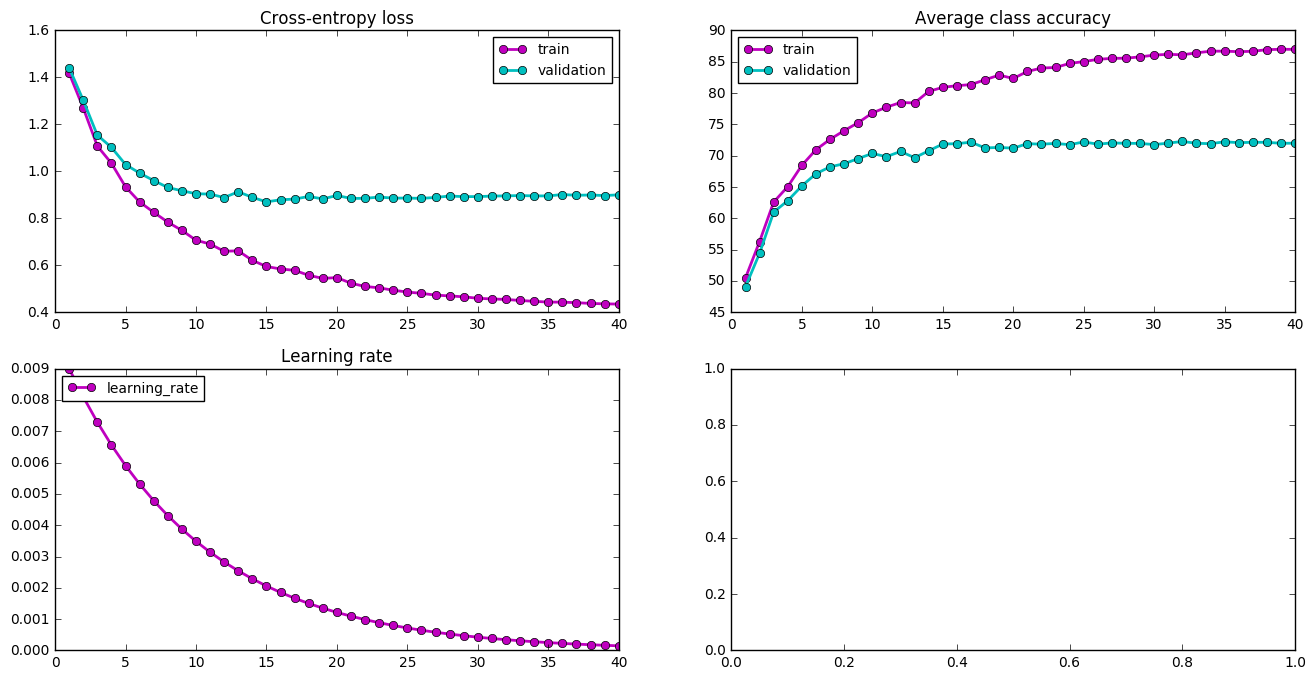

In [12]:
plot_training_progress(plot_data)

## load/store util

In [13]:
from time import strftime

def timestamp_str():
    return time.strftime('%d_%m_%y__%H_%M_%S')

def save(saver, path):
    save_path = saver.save(session, path)
    print("Model saved in file: %s" % save_path)

def restore(saver, sess, path):
    saver.restore(sess, path)
    print("Model restored.")
    



## Store model

In [14]:
saver = tf.train.Saver()
path = "cross_entropy_" + timestamp_str()
save(saver, path)

Model saved in file: cross_entropy_16_11_16__13_16_06


## Restore model

In [15]:
saver = tf.train.Saver()
session = tf.Session()
path = 'cross_entropy_16_11_16__13_16_06'
restore(saver, session, path)

Model restored.


In [16]:
evaluate(session, test_x, test_y, config)

 accuracy = 72.38
 avg loss = 0.91



(0.90954380258917811, 72.379999999999995)

# Top20 worst samples

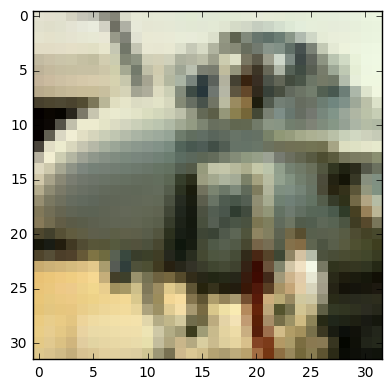

Correct class: airplane
Predictions: ['horse' 'deer' 'cat'] [  9.99848843e-01   1.11126254e-04   2.89993550e-05]


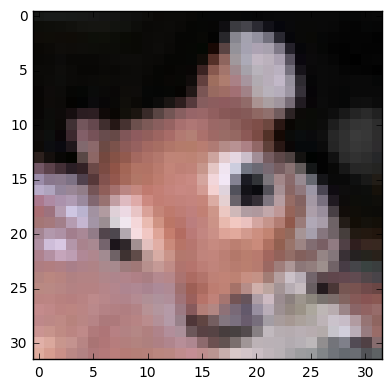

Correct class: deer
Predictions: ['dog' 'cat' 'horse'] [  9.94388402e-01   5.37793571e-03   9.05576962e-05]


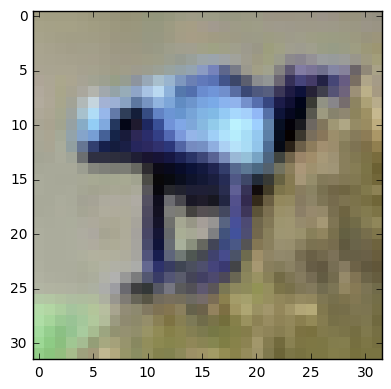

Correct class: frog
Predictions: ['horse' 'dog' 'bird'] [ 0.89383131  0.05330016  0.04800893]


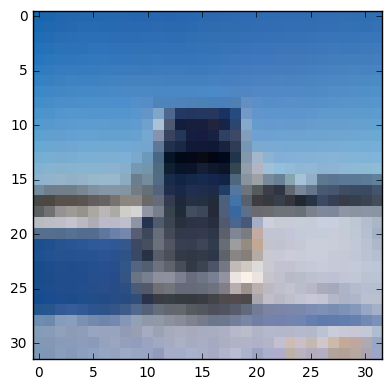

Correct class: truck
Predictions: ['airplane' 'bird' 'ship'] [  9.98240471e-01   1.24579167e-03   3.56675824e-04]


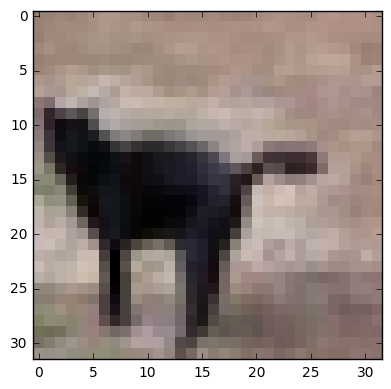

Correct class: cat
Predictions: ['deer' 'bird' 'airplane'] [  9.98167157e-01   9.16076242e-04   8.20576272e-04]


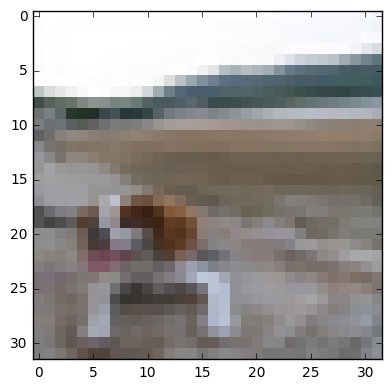

Correct class: dog
Predictions: ['airplane' 'ship' 'bird'] [ 0.57816106  0.39806956  0.02050139]


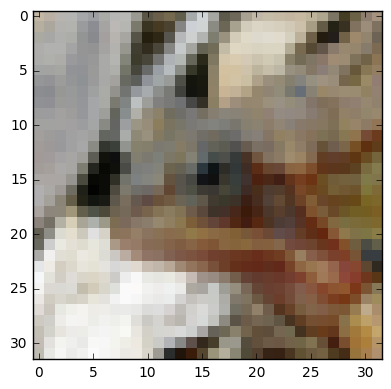

Correct class: frog
Predictions: ['horse' 'deer' 'cat'] [ 0.76235628  0.20324112  0.01791652]


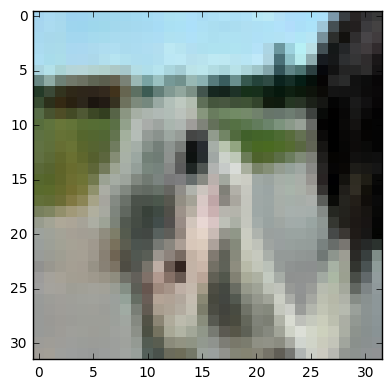

Correct class: bird
Predictions: ['dog' 'cat' 'deer'] [ 0.87271261  0.10137105  0.02261798]


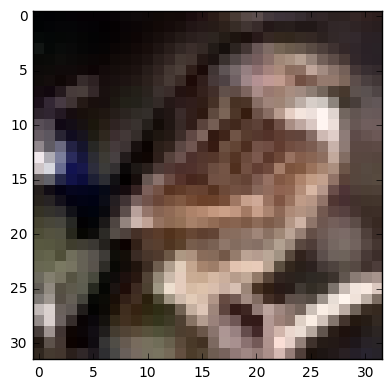

Correct class: bird
Predictions: ['frog' 'cat' 'dog'] [ 0.98623419  0.01227473  0.00147154]


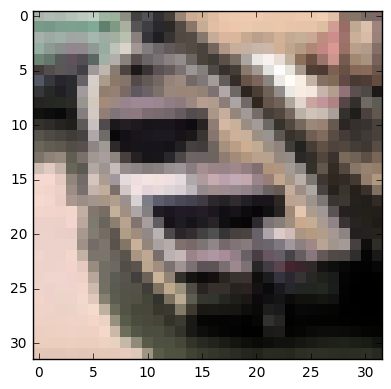

Correct class: ship
Predictions: ['automobile' 'horse' 'bird'] [ 0.99023378  0.00679392  0.0013372 ]


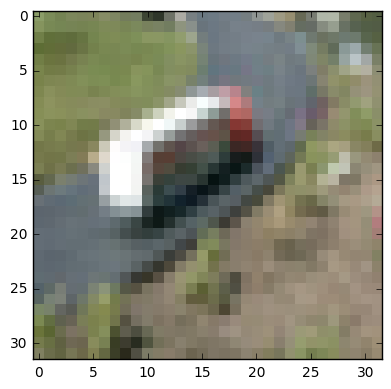

Correct class: truck
Predictions: ['bird' 'dog' 'horse'] [ 0.94124609  0.03952928  0.01007745]


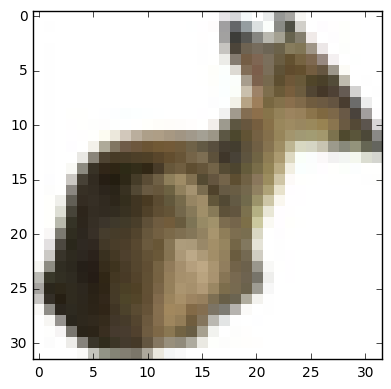

Correct class: deer
Predictions: ['frog' 'cat' 'horse'] [ 0.85482937  0.07926077  0.06083864]


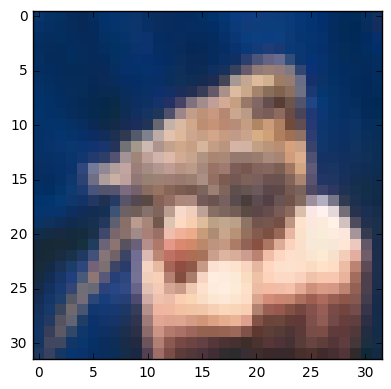

Correct class: bird
Predictions: ['frog' 'ship' 'dog'] [ 0.68406302  0.17504705  0.11892669]


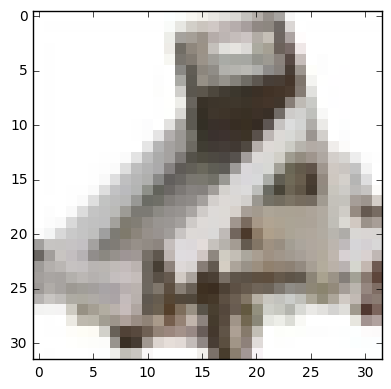

Correct class: truck
Predictions: ['bird' 'cat' 'dog'] [ 0.930327    0.05802681  0.00656901]


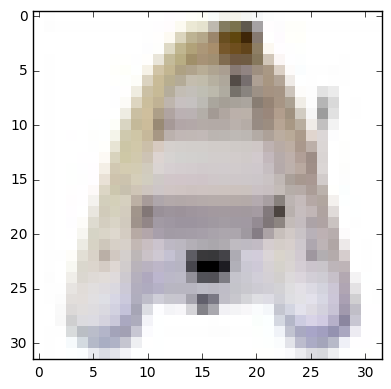

Correct class: ship
Predictions: ['airplane' 'bird' 'cat'] [ 0.3746466   0.24759936  0.16961867]


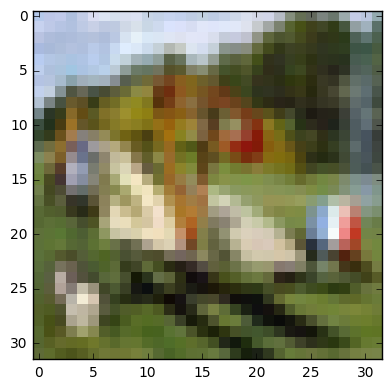

Correct class: airplane
Predictions: ['frog' 'truck' 'bird'] [ 0.98302805  0.01106337  0.0044292 ]


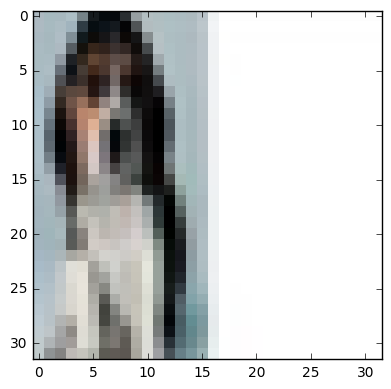

Correct class: dog
Predictions: ['horse' 'bird' 'deer'] [ 0.99402738  0.00395891  0.00184479]


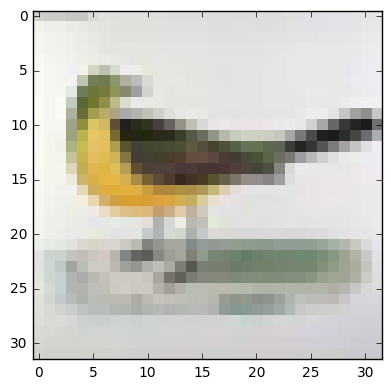

Correct class: bird
Predictions: ['airplane' 'bird' 'ship'] [  9.99904633e-01   8.21952490e-05   1.12792395e-05]


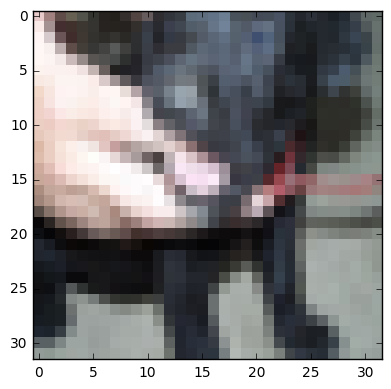

Correct class: dog
Predictions: ['deer' 'airplane' 'bird'] [ 0.96660513  0.01140176  0.00901506]


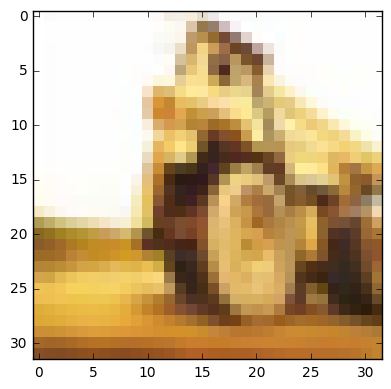

Correct class: truck
Predictions: ['horse' 'dog' 'cat'] [ 0.68510348  0.16727675  0.1446448 ]


In [17]:
worst = worst_samples(session, test_x, test_y, config)

for sample_id, l, predicted in worst:
    show_image(test_x[sample_id], data_mean, data_std)
    probas = session.run(tf.nn.softmax(logits), feed_dict={X: np.array([test_x[sample_id]])})
    probas = probas[0]
    predictions  = np.argsort(-probas)

    print("Correct class:", class_names[test_y[sample_id]])
    print("Predictions:", class_names[predictions[:3]], probas[predictions[:3]])

# Multiclass hinge loss

In [18]:
def multi_class_hinge_loss(logits, label, n_classes, delta=10):
    label_oh = tf.one_hot(label, depth=n_classes, dtype=tf.float32)
    mask = 1-label_oh
    
    correct_logits = tf.diag(tf.reduce_sum(label_oh * logits, 1))
    correct_logits_mat = tf.matmul(correct_logits, tf.ones_like(logits))
    
    errors = tf.nn.relu(logits - correct_logits_mat + delta)
    return errors * mask
    

# New net

In [19]:
# Graph
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y_ = tf.placeholder(tf.int32, [None,])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss(weights.values())
loss_per_sample = multi_class_hinge_loss(logits, Y_, n_classes)
data_loss = tf.reduce_mean(loss_per_sample)
loss = data_loss + weight_decay*regularizers


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 900, 0.9, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


In [20]:
session = tf.Session()
train_start = time.time()

plot_data={}
train(session, train_x, train_y, valid_x, valid_y, config, plot_data)

print("Total train time:", time.time() - train_start)

epoch 1, step 50 / 900, loss = 8.66 (0.006 sec/batch)
epoch 1, step 100 / 900, loss = 6.39 (0.006 sec/batch)


/home/mratkovic/.virtualenvs/py27_tf_env/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


epoch 1, step 150 / 900, loss = 5.63 (0.006 sec/batch)
epoch 1, step 200 / 900, loss = 4.10 (0.007 sec/batch)
epoch 1, step 250 / 900, loss = 4.86 (0.006 sec/batch)
epoch 1, step 300 / 900, loss = 4.85 (0.006 sec/batch)
epoch 1, step 350 / 900, loss = 3.87 (0.006 sec/batch)
epoch 1, step 400 / 900, loss = 3.29 (0.006 sec/batch)
epoch 1, step 450 / 900, loss = 3.45 (0.006 sec/batch)
epoch 1, step 500 / 900, loss = 3.84 (0.006 sec/batch)
epoch 1, step 550 / 900, loss = 4.25 (0.006 sec/batch)
epoch 1, step 600 / 900, loss = 3.51 (0.006 sec/batch)
epoch 1, step 650 / 900, loss = 2.44 (0.006 sec/batch)
epoch 1, step 700 / 900, loss = 2.69 (0.006 sec/batch)
epoch 1, step 750 / 900, loss = 3.21 (0.006 sec/batch)
epoch 1, step 800 / 900, loss = 3.82 (0.006 sec/batch)
epoch 1, step 850 / 900, loss = 3.45 (0.006 sec/batch)
epoch 1, step 900 / 900, loss = 4.06 (0.006 sec/batch)
Train error:
 accuracy = 48.43
 avg loss = 3.03

Validation error:
 accuracy = 46.66
 avg loss = 3.11

Epoch time: 7.761

 accuracy = 72.35
 avg loss = 1.47



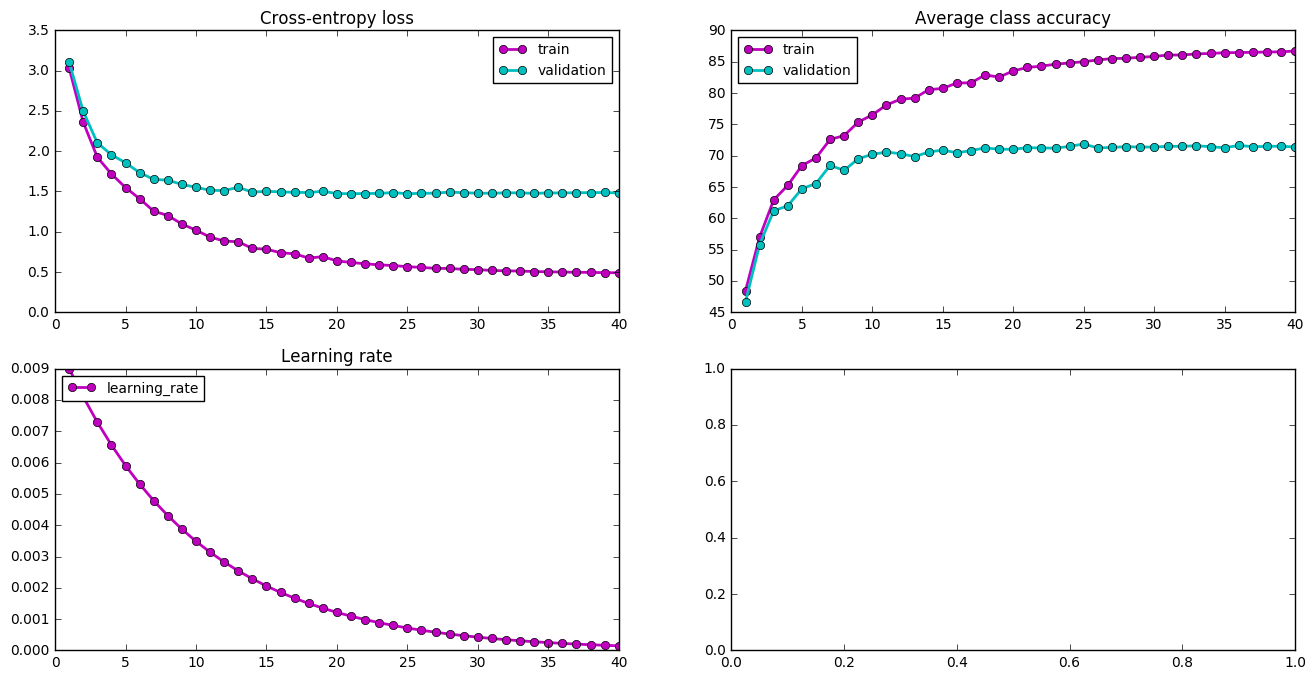

In [21]:
evaluate(session, test_x, test_y, config)
plot_training_progress(plot_data)

In [22]:
saver = tf.train.Saver()
path = "hinge_loss_" + timestamp_str()
save(saver, path)

Model saved in file: hinge_loss_16_11_16__13_23_11
